# Total LeNet-5 compression compare

In [1]:
PATH_PREFIX = '../../'
import sys
sys.path.append(PATH_PREFIX)

In [2]:
import torch
import torch.nn as nn
import pandas as pd
import os
import matplotlib.pyplot as plt

from data.mnist import MnistDataset
from data.utils.mnist_utils import *
from models.lenet.lenet import LeNet5
from utils.weight_sharing import *
from utils.plot import *

Setting parameters

In [3]:
# net settings
LEARNING_RATE = 0.0001
BATCH_SIZE = 32
N_CLASSES = 10
DEVICE = None
EPOCHS = 100
NET_TYPE = 'relu'
CLUST_ALG = 'gmm'

# search settings
SEARCH_RANGE = range(1, 51)
PRECISION_RED = 'f4'

NET_PATH =  os.path.join(PATH_PREFIX, f'models/lenet/saves/lenet_{NET_TYPE}.save')
SAVE_DATA = os.path.join(PATH_PREFIX, f'results/lenet_complete_share/complete_lenet_{NET_TYPE}_share_{PRECISION_RED}_{CLUST_ALG}.csv')

Initing model and dataset

In [4]:
dataset = MnistDataset(BATCH_SIZE, os.path.join(PATH_PREFIX, 'data'), val_split=0.5)
model = LeNet5(N_CLASSES, NET_TYPE)
criterion = nn.CrossEntropyLoss()

lam_opt = lambda mod : torch.optim.Adam(mod.parameters(), lr=LEARNING_RATE)
lam_train = lambda opt, epochs : train_net(model, criterion, opt, dataset, epochs, device=DEVICE)
lam_test = lambda : get_accuracy(model, dataset.test_dl, DEVICE)

optimizer = lam_opt(model)
train_settings = [criterion, optimizer, dataset, EPOCHS, DEVICE, 1, True]

get_trained(model, NET_PATH, train_settings)

ws_controller = WeightShare(model, lam_test, lam_opt, lam_train)
ws_controller.set_reset()
ws_controller.print_layers_info()

layer_name #weights #bias w_locked CR
feature_extractor.0 150 6 False 1.00
feature_extractor.3 2400 16 False 1.00
feature_extractor.6 48000 120 False 1.00
classifier.0 10080 84 False 1.00
classifier.2 840 10 False 1.00
Sum num weights, bias:  61470 236
Compression rate 1.00


Computing bedore compression loss

In [5]:
before_acc = lam_test()
before_acc

0.9846

Load or create the data

In [6]:
if os.path.isfile(SAVE_DATA):
    df = pd.read_csv(SAVE_DATA)
else:
    df = {
        'num_vals': [],
        'compression': [],
        'accuracy': [],
        'inertia': []
    }

    # generating data
    for value in SEARCH_RANGE:
        perf = ws_controller.share_total(value, prec_rtype=PRECISION_RED, clust_alg=CLUST_ALG)
        ws_controller.reset()
        df['num_vals'].append(value)
        df['compression'].append(perf['compression'])
        df['accuracy'].append(perf['accuracy'])
        df['inertia'].append(perf['inertia'])

    df = pd.DataFrame(df)
    df['accuracy_loss'] = before_acc - df['accuracy']
    df.to_csv(SAVE_DATA)
df[df['accuracy_loss'] < 0.01].sort_values(by=['compression'], ascending=False)

,num_vals,compression,accuracy,inertia,accuracy_loss
10,11,7.997138,0.9792,0,0.0054
12,13,7.996618,0.9788,0,0.0058
13,14,7.996358,0.9756,0,0.0090
14,15,7.996098,0.9774,0,0.0072
15,16,7.995838,0.9798,0,0.0048
16,17,6.396816,0.9810,0,0.0036
17,18,6.396628,0.9824,0,0.0022
18,19,6.396441,0.9832,0,0.0014
19,20,6.396254,0.9832,0,0.0014
20,21,6.396067,0.9836,0,0.0010


Plotting results

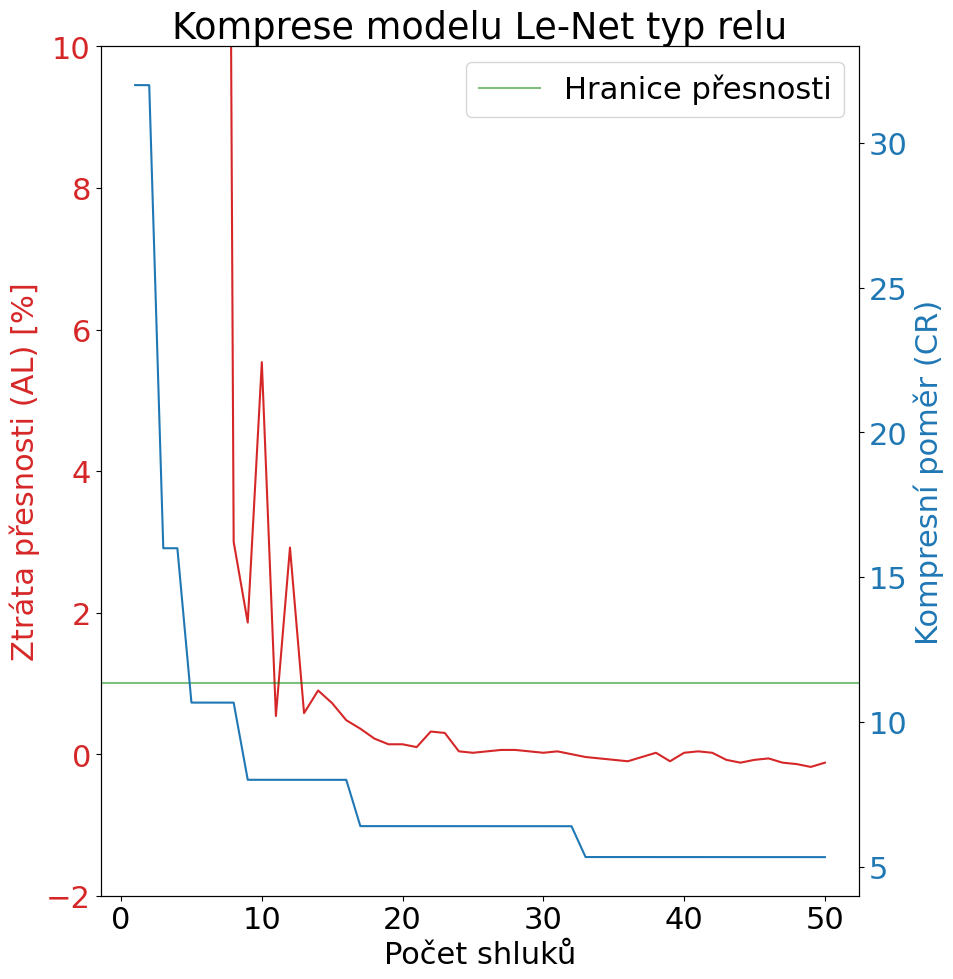

In [7]:
plt.rcParams.update({'font.size': 22})
fig, ax1 = plt.subplots(figsize=(10,10))

color = 'tab:red'
ax1.set_xlabel('Počet shluků')
ax1.set_ylabel('Ztráta přesnosti (AL) [%]', color=color)
ax1.plot(df['num_vals'], df['accuracy_loss'] * 100, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim((-2, 10))
plt.axhline(1, color='green', alpha=0.5, label='Hranice přesnosti')
plt.legend()

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Kompresní poměr (CR)', color=color)
ax2.plot(df['num_vals'], df['compression'], color=color)
ax2.tick_params(axis='y', labelcolor=color)


fig.tight_layout()
plt.title(f'Komprese modelu Le-Net typ {NET_TYPE}')
plt.savefig(os.path.join(PATH_PREFIX, f'results/graphs/lenet_complete_{NET_TYPE}_{PRECISION_RED}.pdf'))
plt.show()
